# CleanCarChecker


In [7]:
import tensorflow as tf
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np

## Preprocessing of data
* Normalizing input (rescale)
* Slight rotation and width/height shift
* Vertical flips

In [18]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=(0.9, 1.1),
    horizontal_flip=True
)

## Load training data

* Size: 500 x 250
* Batch size of 32 is good default value

In [19]:
train_dir = "./data_clean"
IMG_WIDTH = 600
IMG_HEIGHT = 400
batch_size = 32

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

print(train_data_gen.class_indices)

Found 1992 images belonging to 2 classes.
{'cars': 0, 'e-cars': 1}


## Display samples from training set
* for verification of image processing

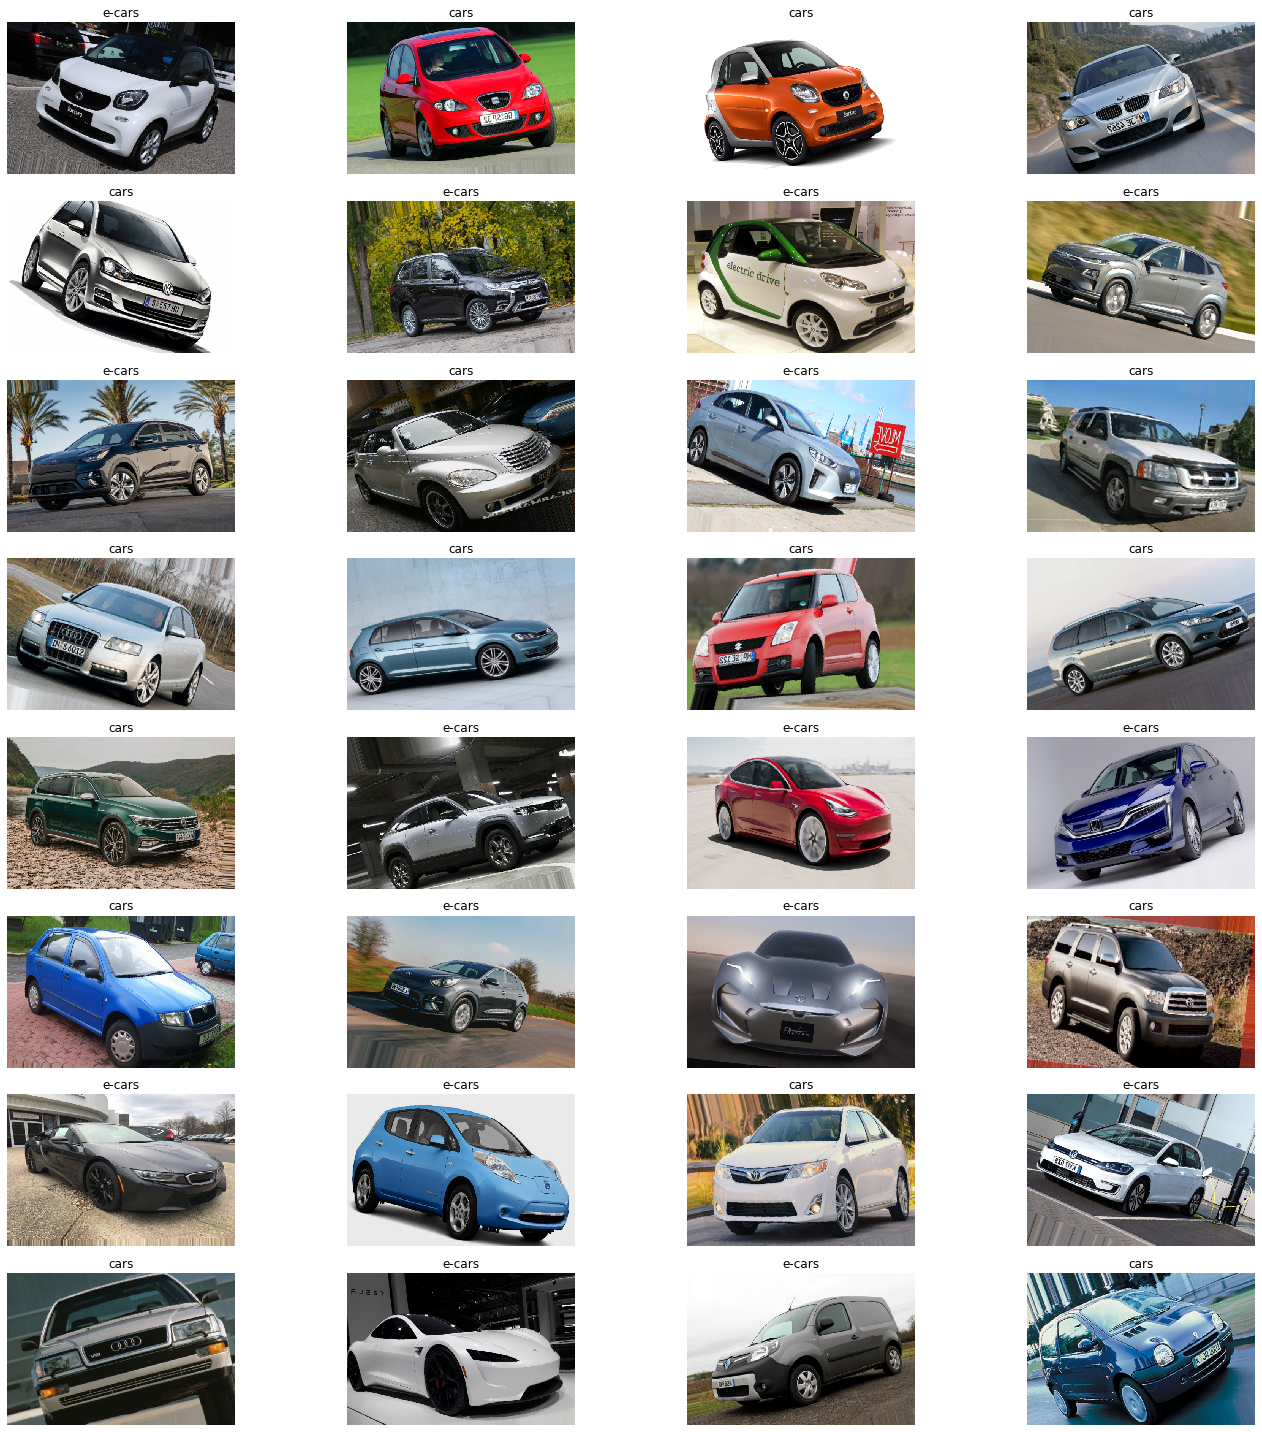

In [20]:
sample_training_images, labels = next(train_data_gen)
class_label = {v:k for k,v in train_data_gen.class_indices.items()}
fig, axes = plt.subplots(8, 4, figsize=(20,20))
axes = axes.flatten()
for img, label, ax in zip(sample_training_images, labels, axes):
    ax.set_title(class_label[np.argmax(label)])
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()